In [1]:
import sqlalchemy as db
import pandas as pd

In [2]:
engine = db.create_engine("sqlite:///mta_data.db")

In [3]:
df = pd.read_sql("SELECT * FROM mta_data;", engine)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17191756 entries, 0 to 17191755
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 1.4+ GB


In [5]:
def get_daily_counts(row, max_counter, turnstile_direction):
    count_name = turnstile_direction
    prev_count_name = f"PREV_{turnstile_direction}"
    counter = row[count_name] - row[prev_count_name]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0?
        print(row[count_name], row[prev_count_name])
        counter = min(row[count_name], row[prev_count_name])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [6]:
import calendar

def stations_monthly(data, stations, month, year, turnstile_direction):
    data = data[data.STATION.isin(stations)]
    data.loc[:, "DATE_FORMATTED"] = pd.to_datetime(data.loc[:, "DATE"])
    data = data[(data.DATE_FORMATTED.dt.month == month) & (data.DATE_FORMATTED.dt.year == year)]
    turnstiles_daily = (data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_FORMATTED"],as_index=False)[turnstile_direction].max())
    turnstiles_daily[["PREV_DATE", f"PREV_{turnstile_direction}"]] = turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE_FORMATTED", turnstile_direction]].shift(1)
    turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    turnstiles_daily[f"DAILY_{turnstile_direction}"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=15000, turnstile_direction=turnstile_direction)
    print(turnstiles_daily[f"DAILY_{turnstile_direction}"].describe().apply(lambda x: '%.0f' % x))
    print(turnstiles_daily.groupby("STATION").size())
    station_totals = turnstiles_daily.groupby("STATION")[f"DAILY_{turnstile_direction}"].sum()
    return station_totals.rename(f"{calendar.month_abbr[month].upper()}_{turnstile_direction}")

In [7]:
crazy_stations = ['GRD CNTRL-42 ST', 'WALL ST', 'HOWARD BCH JFK', '161/YANKEE STAD', 'CONEY IS-STILLW', '116 ST-COLUMBIA', 'FORDHAM RD', 'BRONX PARK EAST', 'BEACH 67 ST', 'JAMAICA VAN WK', 'BROOKLYN BRIDGE', 'LAFAYETTE AV', 'STEINWAY ST', '14 ST']

In [8]:
def station_percent_change(month, turnstile_direction, data=df, stations=crazy_stations, newer_year=2021, older_year=2019):
    newer_month_count = stations_monthly(data, stations, month, newer_year, turnstile_direction)
    older_month_count = stations_monthly(data, stations, month, older_year, turnstile_direction)

    count_change = (newer_month_count - older_month_count) / older_month_count * 100
    return count_change.round(1)

In [106]:
ss = []

for month_num in range(1,10):
    ss.append(station_percent_change(month_num, "ENTRIES"))
    ss.append(station_percent_change(month_num, "EXITS"))

changes_19_21 = pd.concat(ss, axis=1)
changes_19_21 = changes_19_21.sort_values(by="JAN_ENTRIES")

/Users/william.bell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


66 500623.0
19432 84959.0
191 2811568.0
779 2844722.0
358 65004.0
count    10016
mean       192
std        267
min          0
25%          3
50%         96
75%        260
max       2250
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
460379 509427.0
199021 466112.0
1629 2353351.0
count    8934
mean     1027
std      1121
min         0
25%       132
50%       696
75%      1576
max      6734
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1200
161/YANKEE STAD    1050
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     509
CONEY IS-STILLW     600
FORDHAM RD          480
GRD CNTRL-42 ST    1945
HOWA

578 16034.0
715 195207.0
526 8377614.0
920 58914.0
2020 5739414.0
17 900047.0
65572 17.0
1428 55811.0
4702 3537698.0
3869 13835021.0
1510932084 6539833.0
126 69628.0
count     8924
mean       902
std       1242
min          0
25%        138
50%        512
75%       1229
max      13004
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     173
14 ST              1362
161/YANKEE STAD    1073
BEACH 67 ST         145
BRONX PARK EAST      87
BROOKLYN BRIDGE     492
CONEY IS-STILLW     580
FORDHAM RD          464
GRD CNTRL-42 ST    1880
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
STEINWAY ST         261
WALL ST            1450
dtype: int64
101 2651127.0
count    10066
mean       265
std        327
min          0
25%         31
50%        164
75%        363
max       2632
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1530
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CON

458754 3774.0
22 2129136933.0
21 13593868.0
27 7808626.0
1962917910 9137598.0
458755 0.0
117 545570.0
1246 460155.0
4245 393407.0
2503 1285262.0
3173 10213754.0
4908 57522.0
1 117208.0
197 57519.0
count    9213
mean     1019
std      1034
min         0
25%       189
50%       766
75%      1502
max      6917
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1396
161/YANKEE STAD    1102
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     508
CONEY IS-STILLW     600
FORDHAM RD          479
GRD CNTRL-42 ST    1962
HOWARD BCH JFK      466
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
164 767349.0
604001837 2369108.0
count    10070
mean       363
std        475
min          0
25%         47
50%        209
75%        481
max       4055
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1530
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PAR

In [110]:
changes_19_21

,JAN_ENTRIES,JAN_EXITS,FEB_ENTRIES,FEB_EXITS,MAR_ENTRIES,MAR_EXITS,APR_ENTRIES,APR_EXITS,MAY_ENTRIES,MAY_EXITS,JUN_ENTRIES,JUN_EXITS,JUL_ENTRIES,JUL_EXITS,AUG_ENTRIES,AUG_EXITS,SEP_ENTRIES,SEP_EXITS
STATION,,,,,,,,,,,,,,,,,,
WALL ST,-85.7,-81.0,-84.9,-78.4,-83.1,-77.9,-83.3,-77.9,-81.0,-74.0,-77.3,-70.1,-76.1,-67.8,-75.0,-64.2,-75.3,-64.5
GRD CNTRL-42 ST,-85.4,-78.8,-84.5,-76.9,-82.4,-74.2,-82.1,-73.9,-80.3,-70.6,-75.5,-63.3,-74.1,-60.3,-73.5,-60.1,-72.7,-57.9
116 ST-COLUMBIA,-83.4,-73.3,-86.5,-76.8,-82.9,-69.8,-83.7,-69.2,-79.6,-62.3,-70.1,-47.0,-72.1,-48.7,-65.7,-40.1,-61.5,-28.5
BROOKLYN BRIDGE,-83.0,-77.6,-83.4,-76.9,-81.1,-73.6,-81.3,-71.8,-78.5,-69.0,-73.1,-62.6,-71.0,-59.8,-71.2,-58.2,-67.0,-55.2
14 ST,-80.3,-69.4,-80.4,-69.4,-78.0,-66.9,-75.8,-63.8,-74.0,-59.2,-69.0,-49.4,-66.8,-45.0,-65.6,-44.5,-65.8,-46.5
STEINWAY ST,-74.7,-61.5,-70.8,-55.7,-70.1,-56.3,-68.7,-55.6,-62.3,-42.7,-63.4,-49.3,-65.4,-45.5,-59.8,-44.2,-58.4,-40.7
LAFAYETTE AV,-73.2,-56.6,-71.9,-59.4,-70.5,-52.8,-67.7,-48.4,-67.9,-45.0,-69.5,-48.8,-64.3,-37.2,-61.6,-31.0,-59.4,-32.7
HOWARD BCH JFK,-66.2,-90.3,-66.7,-89.9,-66.8,-90.1,-62.7,-88.5,-51.0,-84.4,-57.2,-72.4,-51.3,-66.4,-51.6,-66.8,-51.7,-64.0
161/YANKEE STAD,-62.1,-52.6,-59.6,-48.2,-60.3,-49.0,-65.3,-56.5,-65.5,-56.2,-61.3,-45.6,-58.3,-43.7,-57.9,-43.6,-55.4,-36.4


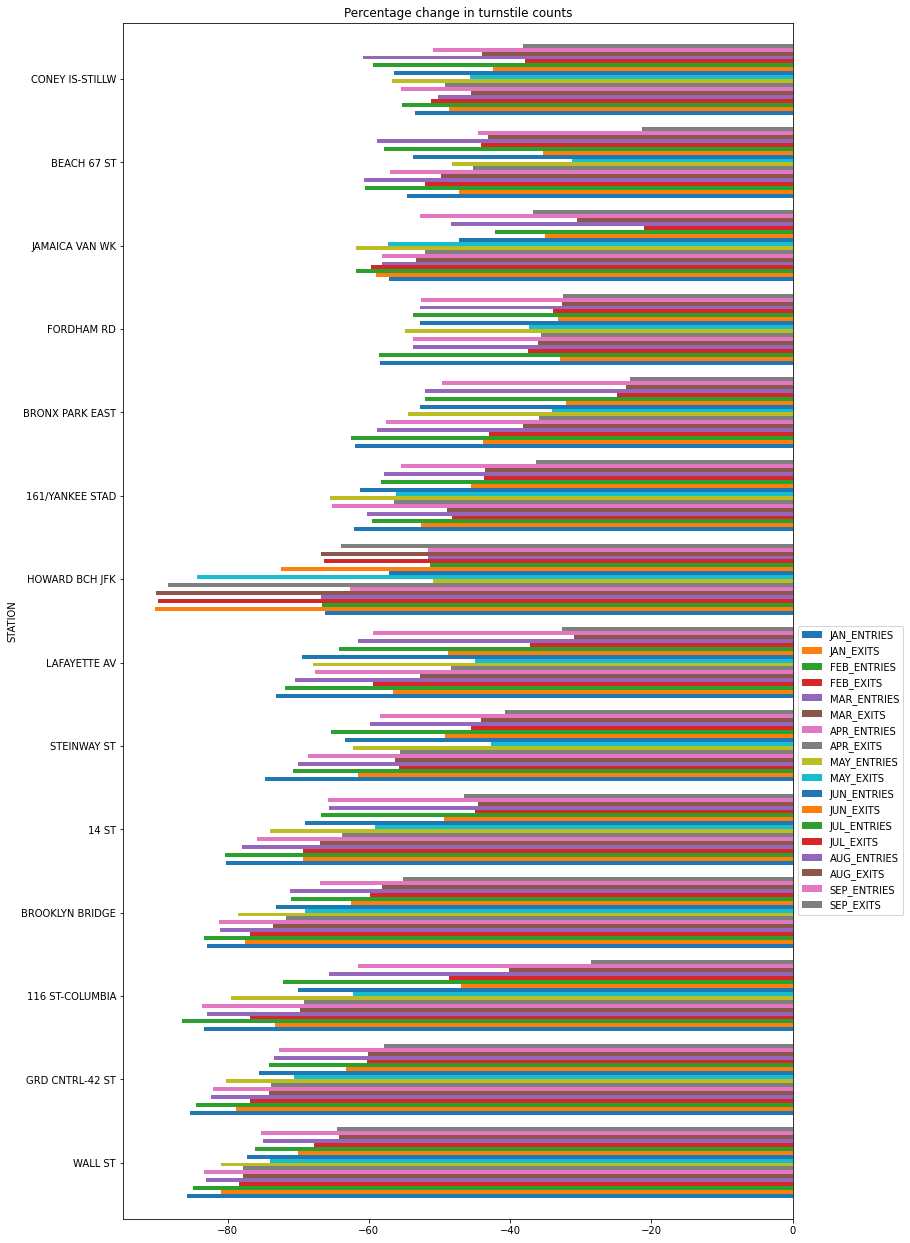

In [112]:
changes_19_21.plot.barh(title="Percentage change in turnstile counts", figsize=(12,22), width=0.85).legend(bbox_to_anchor=(1,0.5))

In [113]:
entries_19_21 = changes_19_21[changes_19_21.columns[::2]]
entires_19_21 = entries_19_21.sort_values(by="JAN_ENTRIES")
entries_19_21

,JAN_ENTRIES,FEB_ENTRIES,MAR_ENTRIES,APR_ENTRIES,MAY_ENTRIES,JUN_ENTRIES,JUL_ENTRIES,AUG_ENTRIES,SEP_ENTRIES
STATION,,,,,,,,,
WALL ST,-85.7,-84.9,-83.1,-83.3,-81.0,-77.3,-76.1,-75.0,-75.3
GRD CNTRL-42 ST,-85.4,-84.5,-82.4,-82.1,-80.3,-75.5,-74.1,-73.5,-72.7
116 ST-COLUMBIA,-83.4,-86.5,-82.9,-83.7,-79.6,-70.1,-72.1,-65.7,-61.5
BROOKLYN BRIDGE,-83.0,-83.4,-81.1,-81.3,-78.5,-73.1,-71.0,-71.2,-67.0
14 ST,-80.3,-80.4,-78.0,-75.8,-74.0,-69.0,-66.8,-65.6,-65.8
STEINWAY ST,-74.7,-70.8,-70.1,-68.7,-62.3,-63.4,-65.4,-59.8,-58.4
LAFAYETTE AV,-73.2,-71.9,-70.5,-67.7,-67.9,-69.5,-64.3,-61.6,-59.4
HOWARD BCH JFK,-66.2,-66.7,-66.8,-62.7,-51.0,-57.2,-51.3,-51.6,-51.7
161/YANKEE STAD,-62.1,-59.6,-60.3,-65.3,-65.5,-61.3,-58.3,-57.9,-55.4


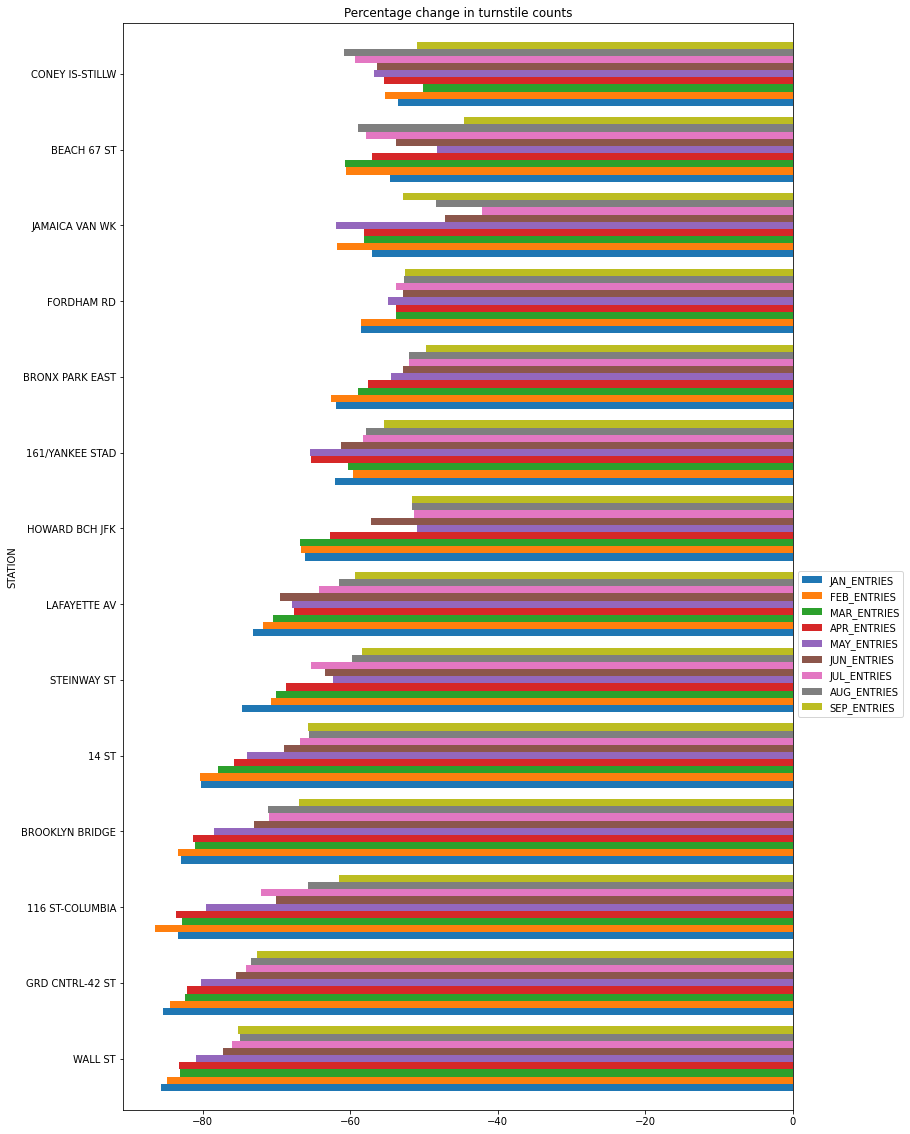

In [114]:
entries_19_21.plot.barh(title="Percentage change in turnstile counts", figsize=(12,20), width=0.85).legend(bbox_to_anchor=(1,0.5))

In [17]:
entries_transposed = entries_19_21.transpose()
entries_transposed = entries_transposed.apply(lambda x: -x)
entries_transposed = entries_transposed[entries_transposed.columns[::-1]]
entries_transposed

STATION,WALL ST,GRD CNTRL-42 ST,116 ST-COLUMBIA,BROOKLYN BRIDGE,14 ST,STEINWAY ST,LAFAYETTE AV,HOWARD BCH JFK,161/YANKEE STAD,BRONX PARK EAST,FORDHAM RD,JAMAICA VAN WK,BEACH 67 ST,CONEY IS-STILLW
JAN_ENTRIES,85.7,85.4,83.4,83.0,80.3,74.7,73.2,66.2,62.1,62.0,58.5,57.1,54.6,53.5
FEB_ENTRIES,84.9,84.5,86.5,83.4,80.4,70.8,71.9,66.7,59.6,62.6,58.6,61.8,60.6,55.3
MAR_ENTRIES,83.1,82.4,82.9,81.1,78.0,70.1,70.5,66.8,60.3,58.9,53.8,58.2,60.7,50.2
APR_ENTRIES,83.3,82.1,83.7,81.3,75.8,68.7,67.7,62.7,65.3,57.6,53.8,58.2,57.0,55.5
MAY_ENTRIES,81.0,80.3,79.6,78.5,74.0,62.3,67.9,51.0,65.5,54.5,54.9,61.9,48.3,56.8
JUN_ENTRIES,77.3,75.5,70.1,73.1,69.0,63.4,69.5,57.2,61.3,52.8,52.8,47.2,53.8,56.4
JUL_ENTRIES,76.1,74.1,72.1,71.0,66.8,65.4,64.3,51.3,58.3,52.1,53.8,42.1,57.9,59.4
AUG_ENTRIES,75.0,73.5,65.7,71.2,65.6,59.8,61.6,51.6,57.9,52.0,52.7,48.4,58.9,60.9
SEP_ENTRIES,75.3,72.7,61.5,67.0,65.8,58.4,59.4,51.7,55.4,49.7,52.6,52.8,44.6,50.9


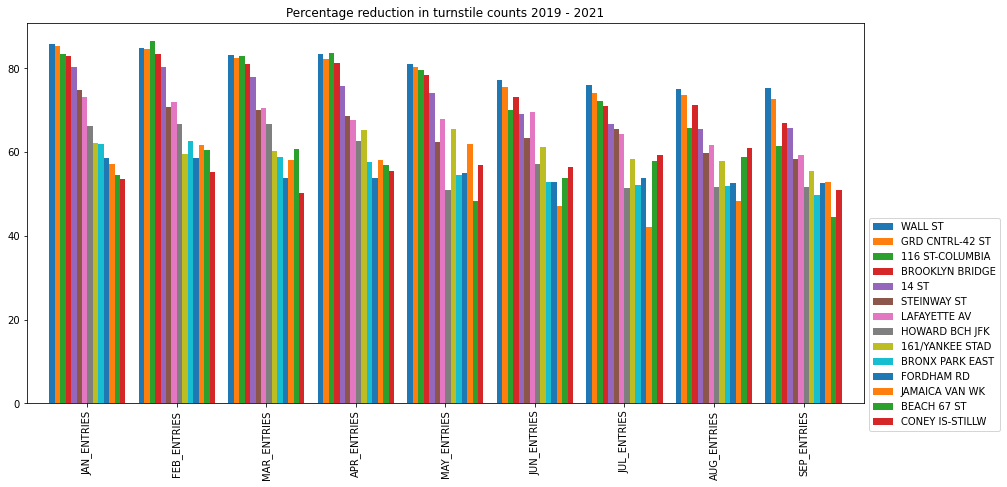

In [18]:
entries_transposed.plot.bar(title="Percentage reduction in turnstile counts 2019 - 2021", figsize=(15,7), width=0.85).legend(bbox_to_anchor=(1,0.5))

In [19]:
june_total_entries = stations_monthly(df, crazy_stations, 6, 2021, "ENTRIES")
june_total_entries.sort_values(inplace=True)

/Users/william.bell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


393219 459438.0
42 72848.0
687970551 19471253.0
458753 393246.0
303 37239.0
80 22516.0
count    9698
mean      311
std       362
min         0
25%        47
50%       211
75%       431
max      2888
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     174
14 ST              1479
161/YANKEE STAD    1072
BEACH 67 ST         145
BRONX PARK EAST      87
BROOKLYN BRIDGE     493
CONEY IS-STILLW     579
FORDHAM RD          464
GRD CNTRL-42 ST    2568
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
STEINWAY ST         261
WALL ST            1419
dtype: int64


In [20]:
june_total_entries

STATION
BRONX PARK EAST     29958.0
BEACH 67 ST         30456.0
LAFAYETTE AV        39190.0
JAMAICA VAN WK      53492.0
HOWARD BCH JFK      57825.0
116 ST-COLUMBIA     77404.0
BROOKLYN BRIDGE    127939.0
STEINWAY ST        143030.0
CONEY IS-STILLW    230367.0
WALL ST            240364.0
FORDHAM RD         261624.0
161/YANKEE STAD    302649.0
14 ST              516660.0
GRD CNTRL-42 ST    909492.0
Name: JUN_ENTRIES, dtype: float64

In [21]:
june_total_entries.sum()

3020450.0

In [22]:
def total_percent_change(month, data=df, stations=crazy_stations, newer_year=2021, older_year=2019):
    month_total_newer = stations_monthly(data, stations, month, newer_year, "ENTRIES").sum() + stations_monthly(data, stations, month, newer_year, "EXITS").sum()
    month_total_older = stations_monthly(data, stations, month, older_year, "ENTRIES").sum() + stations_monthly(data, stations, month, older_year, "EXITS").sum()

    percent_change = (month_total_newer - month_total_older) / month_total_older * 100
    return percent_change.round(1)

In [24]:
values = []
months = []

for month_num in range(1,10):
    values.append(total_percent_change(month_num))
    months.append(calendar.month_abbr[month_num].upper())

totals_19_21 = pd.Series(values, index=months)
totals_19_21

66 500623.0
19432 84959.0
191 2811568.0
779 2844722.0
358 65004.0
count    10016
mean       192
std        267
min          0
25%          3
50%         96
75%        260
max       2250
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
59 805938.0
23392 153948.0
426 3505140.0
435 2837182.0
213 72227.0
count    10016
mean       202
std        308
min          0
25%          6
50%         89
75%        274
max       3317
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GR

578 16034.0
715 195207.0
526 8377614.0
920 58914.0
2020 5739414.0
17 900047.0
65572 17.0
1428 55811.0
4702 3537698.0
3869 13835021.0
1510932084 6539833.0
126 69628.0
count     8924
mean       902
std       1242
min          0
25%        138
50%        512
75%       1229
max      13004
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     173
14 ST              1362
161/YANKEE STAD    1073
BEACH 67 ST         145
BRONX PARK EAST      87
BROOKLYN BRIDGE     492
CONEY IS-STILLW     580
FORDHAM RD          464
GRD CNTRL-42 ST    1880
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
STEINWAY ST         261
WALL ST            1450
dtype: int64
101 2651127.0
count    10066
mean       265
std        327
min          0
25%         31
50%        164
75%        363
max       2632
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1530
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CON

164 767349.0
604001837 2369108.0
count    10070
mean       363
std        475
min          0
25%         47
50%        209
75%        481
max       4055
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1530
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     600
FORDHAM RD          480
GRD CNTRL-42 ST    2670
HOWARD BCH JFK      470
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
458754 3774.0
22 2129136933.0
21 13593868.0
27 7808626.0
1962917910 9137598.0
458755 0.0
117 545570.0
1246 460155.0
4245 393407.0
2503 1285262.0
3173 10213754.0
4908 57522.0
1 117208.0
197 57519.0
count    9213
mean     1019
std      1034
min         0
25%       189
50%       766
75%      1502
max      6917
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1396
161/YANKEE STAD    1102
BEACH 67 ST         150
BRONX PAR

JAN   -76.1
FEB   -75.3
MAR   -72.8
APR   -72.4
MAY   -69.6
JUN   -64.1
JUL   -61.9
AUG   -61.0
SEP   -59.5
dtype: float64

In [25]:
totals_19_21 = totals_19_21.apply(lambda x: -x)

<AxesSubplot:title={'center':'Percentage reduction in turnstile counts'}>

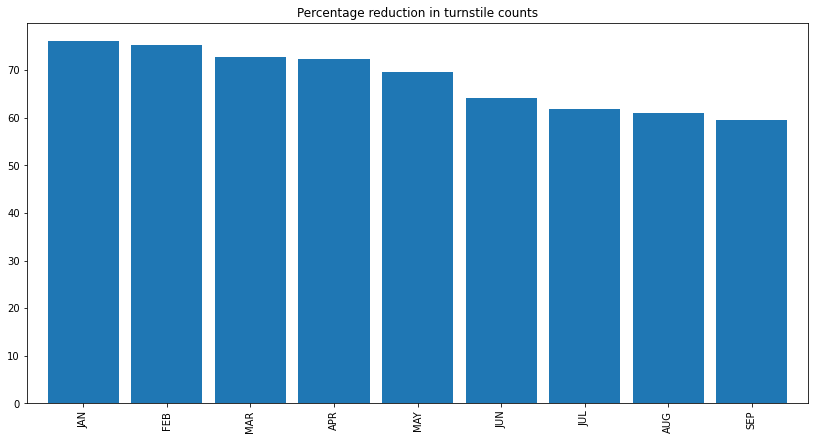

In [42]:
totals_19_21.plot.bar(title="Percentage reduction in turnstile counts", figsize=(14,7), width=0.85)

In [27]:
%store -r monthly_cases
monthly_cases

JAN    137485
FEB     86462
MAR     92016
APR     54334
MAY     13564
JUN      5248
JUL     18689
AUG     45989
SEP     38507
dtype: int64

In [28]:
type(totals_19_21)

pandas.core.series.Series

In [29]:
turnstiles_covid = pd.concat([totals_19_21, monthly_cases], axis=1)

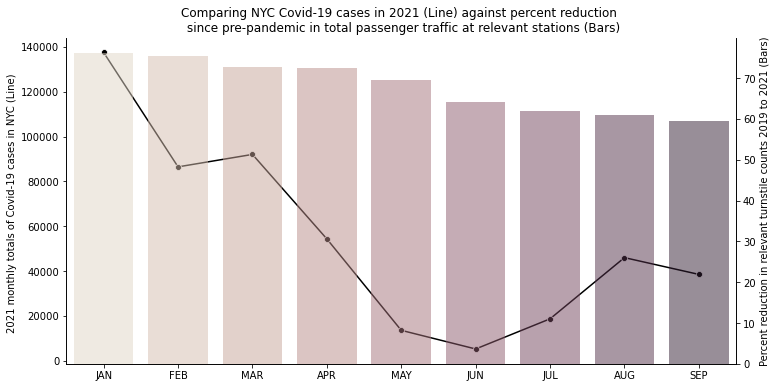

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = turnstiles_covid[1], marker='o', color='black', ax=ax1)
ax2 = ax1.twinx()

sns.barplot(x=turnstiles_covid.index, y=0, palette="ch:.25", data=turnstiles_covid, alpha=0.5, ax=ax2)
ax1.set_title('Comparing NYC Covid-19 cases in 2021 (Line) against percent reduction \n since pre-pandemic in total passenger traffic at relevant stations (Bars)')
ax1.set_ylabel('2021 monthly totals of Covid-19 cases in NYC (Line) ')
ax2.set_ylabel('Percent reduction in relevant turnstile counts 2019 to 2021 (Bars)')
sns.despine(right=False)

plt.savefig('turnstiles_versus_cases.png', dpi=300)

In [32]:
def station_monthly_totals(month, year, data=df, stations=crazy_stations):
    return stations_monthly(data, stations, month, year, "ENTRIES") + stations_monthly(data, stations, month, year, "EXITS")

In [33]:
station_monthly_totals(1, 2021)

/Users/william.bell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


66 500623.0
19432 84959.0
191 2811568.0
779 2844722.0
358 65004.0
count    10016
mean       192
std        267
min          0
25%          3
50%         96
75%        260
max       2250
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
59 805938.0
23392 153948.0
426 3505140.0
435 2837182.0
213 72227.0
count    10016
mean       202
std        308
min          0
25%          6
50%         89
75%        274
max       3317
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GR

STATION
116 ST-COLUMBIA      96331.0
14 ST               675211.0
161/YANKEE STAD     355216.0
BEACH 67 ST          43840.0
BRONX PARK EAST      38415.0
BROOKLYN BRIDGE     150463.0
CONEY IS-STILLW     270004.0
FORDHAM RD          355450.0
GRD CNTRL-42 ST    1235080.0
HOWARD BCH JFK       42387.0
JAMAICA VAN WK      105210.0
LAFAYETTE AV         55997.0
STEINWAY ST         219292.0
WALL ST             307900.0
dtype: float64

In [35]:
series = []

for month_num in range(1,10):
    series.append(station_monthly_totals(month_num, 2021))

totals_21 = pd.concat(series, axis=1)
totals_21

/Users/william.bell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


66 500623.0
19432 84959.0
191 2811568.0
779 2844722.0
358 65004.0
count    10016
mean       192
std        267
min          0
25%          3
50%         96
75%        260
max       2250
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
59 805938.0
23392 153948.0
426 3505140.0
435 2837182.0
213 72227.0
count    10016
mean       202
std        308
min          0
25%          6
50%         89
75%        274
max       3317
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1529
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GR

164 767349.0
604001837 2369108.0
count    10070
mean       363
std        475
min          0
25%         47
50%        209
75%        481
max       4055
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1530
161/YANKEE STAD    1110
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     600
FORDHAM RD          480
GRD CNTRL-42 ST    2670
HOWARD BCH JFK      470
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
1626 557914846.0
393220 458784.0
689 118770.0
count    9873
mean      338
std       408
min         0
25%        43
50%       214
75%       477
max      3341
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     174
14 ST              1479
161/YANKEE STAD    1073
BEACH 67 ST         145
BRONX PARK EAST      87
BROOKLYN BRIDGE     493
CONEY IS-STILLW     565
FORDHAM RD          464
GRD CNTRL-42 ST    2725
HOWARD BCH JFK      464
JAMAICA VAN WK  

,0,1,2,3,4,5,6,7,8
STATION,,,,,,,,,
116 ST-COLUMBIA,96331.0,97515.0,124650.0,132175.0,141134.0,151159.0,152782.0,176432.0,311358.0
14 ST,675211.0,644592.0,820623.0,893677.0,1029060.0,1222773.0,1225691.0,1191022.0,1377676.0
161/YANKEE STAD,355216.0,335878.0,419262.0,437516.0,483621.0,546543.0,572423.0,599352.0,601493.0
BEACH 67 ST,43840.0,36839.0,43221.0,47242.0,62577.0,63633.0,65400.0,61346.0,62413.0
BRONX PARK EAST,38415.0,34403.0,43805.0,45234.0,48173.0,49352.0,49210.0,47588.0,56067.0
BROOKLYN BRIDGE,150463.0,146280.0,195685.0,210000.0,236786.0,274448.0,297561.0,300027.0,352344.0
CONEY IS-STILLW,270004.0,241336.0,309824.0,329965.0,387984.0,468223.0,506575.0,446482.0,407060.0
FORDHAM RD,355450.0,318189.0,397424.0,396729.0,411087.0,414413.0,410358.0,415197.0,433713.0
GRD CNTRL-42 ST,1235080.0,1184185.0,1530536.0,1585008.0,1786955.0,2178316.0,2340999.0,2293275.0,2470691.0


In [37]:
totals_21["sum"] = totals_21.sum(axis=1)
totals_21

,0,1,2,3,4,5,6,7,8,sum
STATION,,,,,,,,,,
116 ST-COLUMBIA,96331.0,97515.0,124650.0,132175.0,141134.0,151159.0,152782.0,176432.0,311358.0,1383536.0
14 ST,675211.0,644592.0,820623.0,893677.0,1029060.0,1222773.0,1225691.0,1191022.0,1377676.0,9080325.0
161/YANKEE STAD,355216.0,335878.0,419262.0,437516.0,483621.0,546543.0,572423.0,599352.0,601493.0,4351304.0
BEACH 67 ST,43840.0,36839.0,43221.0,47242.0,62577.0,63633.0,65400.0,61346.0,62413.0,486511.0
BRONX PARK EAST,38415.0,34403.0,43805.0,45234.0,48173.0,49352.0,49210.0,47588.0,56067.0,412247.0
BROOKLYN BRIDGE,150463.0,146280.0,195685.0,210000.0,236786.0,274448.0,297561.0,300027.0,352344.0,2163594.0
CONEY IS-STILLW,270004.0,241336.0,309824.0,329965.0,387984.0,468223.0,506575.0,446482.0,407060.0,3367453.0
FORDHAM RD,355450.0,318189.0,397424.0,396729.0,411087.0,414413.0,410358.0,415197.0,433713.0,3552560.0
GRD CNTRL-42 ST,1235080.0,1184185.0,1530536.0,1585008.0,1786955.0,2178316.0,2340999.0,2293275.0,2470691.0,16605045.0


In [38]:
series_19 = []

for month_num in range(1,10):
    series_19.append(station_monthly_totals(month_num, 2019))

totals_19 = pd.concat(series_19, axis=1)
totals_19["sum"] = totals_19.sum(axis=1)
totals_19

/Users/william.bell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


460379 509427.0
199021 466112.0
1629 2353351.0
count    8934
mean     1027
std      1121
min         0
25%       132
50%       696
75%      1576
max      6734
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1200
161/YANKEE STAD    1050
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     509
CONEY IS-STILLW     600
FORDHAM RD          480
GRD CNTRL-42 ST    1945
HOWARD BCH JFK      480
JAMAICA VAN WK      210
LAFAYETTE AV        270
STEINWAY ST         270
WALL ST            1500
dtype: int64
984 30402.0
883 1009858.0
count     8934
mean       822
std       1198
min          0
25%        100
50%        420
75%       1110
max      12481
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1200
161/YANKEE STAD    1050
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     509
CONEY IS-STILLW     600
FORDHAM RD          480
GRD CNTRL-42 ST    1945
HOWARD BCH JFK      480
JAMAICA VAN WK      21

458754 3774.0
22 2129136933.0
21 13593868.0
27 7808626.0
1962917910 9137598.0
458755 0.0
117 545570.0
1246 460155.0
4245 393407.0
2503 1285262.0
3173 10213754.0
4908 57522.0
1 117208.0
197 57519.0
count    9213
mean     1019
std      1034
min         0
25%       189
50%       766
75%      1502
max      6917
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
14 ST              1396
161/YANKEE STAD    1102
BEACH 67 ST         150
BRONX PARK EAST      90
BROOKLYN BRIDGE     508
CONEY IS-STILLW     600
FORDHAM RD          479
GRD CNTRL-42 ST    1962
HOWARD BCH JFK      466
JAMAICA VAN WK      210
LAFAYETTE AV        300
STEINWAY ST         270
WALL ST            1500
dtype: int64
16 1155490186.0
14 15837645.0
15 4262196.0
318790192 1305662.0
107 155067.0
327685 442.0
65541 327685.0
1 65541.0
5514 555556.0
2279 878220.0
12769 13304779.0
2 93635.0
count     9213
mean       854
std       1228
min          0
25%        127
50%        481
75%       1150
max      12906
Name: DAIL

,0,1,2,3,4,5,6,7,8,sum
STATION,,,,,,,,,,
116 ST-COLUMBIA,478822.0,580858.0,577887.0,625171.0,535320.0,397732.0,425065.0,409777.0,629504.0,4660136.0
14 ST,2751204.0,2628276.0,3035664.0,3012205.0,3147232.0,3064515.0,2837699.0,2687272.0,3173634.0,26337701.0
161/YANKEE STAD,857716.0,753340.0,958108.0,1153238.0,1273226.0,1230719.0,1214226.0,1260850.0,1168437.0,9869860.0
BEACH 67 ST,90277.0,85619.0,98434.0,98708.0,105700.0,117243.0,135681.0,127866.0,95583.0,955111.0
BRONX PARK EAST,88314.0,79576.0,92698.0,92519.0,92902.0,91994.0,87692.0,83994.0,96238.0,805927.0
BROOKLYN BRIDGE,773243.0,750294.0,880977.0,919776.0,921809.0,866455.0,872826.0,865580.0,916125.0,7767085.0
CONEY IS-STILLW,552850.0,516651.0,594450.0,693996.0,802827.0,942355.0,1020609.0,962719.0,740455.0,6826912.0
FORDHAM RD,733331.0,674320.0,775102.0,772997.0,820023.0,782895.0,786834.0,779332.0,813851.0,6938685.0
GRD CNTRL-42 ST,6977019.0,6211437.0,7134339.0,7270132.0,7352258.0,7178431.0,7174631.0,6923495.0,7135718.0,63357460.0


In [67]:
total_percent_reduction = (totals_19["sum"] - totals_21["sum"]) / totals_19["sum"] * 100
total_percent_reduction = total_percent_reduction.sort_values(ascending=False)
total_percent_reduction = total_percent_reduction.round(1)
total_percent_reduction

STATION
WALL ST            76.7
GRD CNTRL-42 ST    73.8
BROOKLYN BRIDGE    72.1
116 ST-COLUMBIA    70.3
HOWARD BCH JFK     68.8
14 ST              65.5
LAFAYETTE AV       60.6
STEINWAY ST        59.3
161/YANKEE STAD    55.9
CONEY IS-STILLW    50.7
JAMAICA VAN WK     49.9
BEACH 67 ST        49.1
BRONX PARK EAST    48.8
FORDHAM RD         48.8
Name: sum, dtype: float64

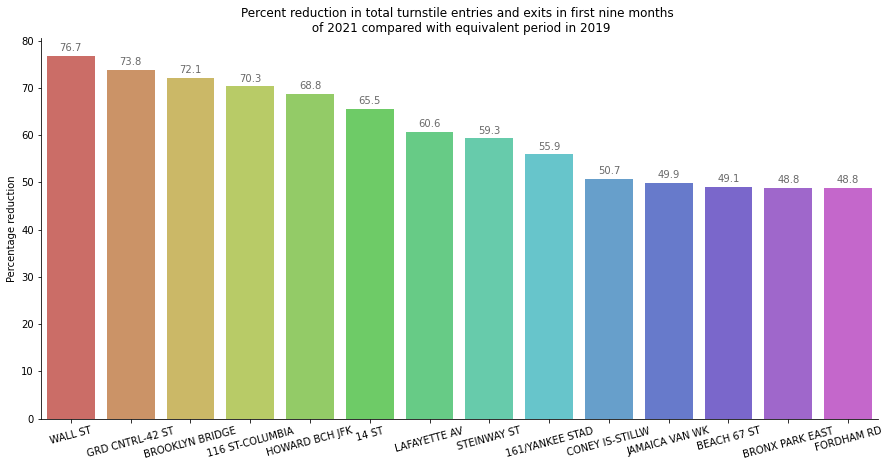

In [123]:
plt.figure(figsize=(15,7))
custom_palette = sns.color_palette("hls", 16)
ax = sns.barplot(x=total_percent_reduction.index, y=total_percent_reduction, palette=custom_palette)
ax.set_title('Percent reduction in total turnstile entries and exits in first nine months \n of 2021 compared with equivalent period in 2019')
ax.set_ylabel('Percentage reduction')
plt.xticks(fontsize = '10', rotation = 15)
plt.yticks(fontsize = '10')
plt.xlabel("")
sns.despine()

#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='dimgray', xytext=(0, 8),
                textcoords='offset points')

plt.savefig("totals_percent_reduction.png", dpi = 300);